# Clasificación de Audio con Redes Neuronales

## Trabajo Práctico - Redes Convolucionales y Recurrentes - 2025

**Tecnicatura Universitaria en Inteligencia Artificial**

### Profesores

* Moreyra, Matias
* Cocitto López, Bruno
* Moreyra, Facundo

### Integrantes

* Borgo Elgart, Iair (Legajo: B-6608/7)
* Flaibani, Marcela (Legajo: F-3793/1)
* Nardi, Albano (Legajo: N-1280/7)

## Introducción

Utilizando el dataset proporcionado, el objetivo es construir un modelo de clasificación utilizando redes neuronales que pueda inferir con precisión el dígito correspondiente dado un clip de audio. Se deben entrenar y evaluar modelos utilizando técnicas adecuadas de validación y métricas de evaluación de clasificación.

## Setup

Importación de Librerías

In [1]:
## Configuración del Entorno e Importación de Librerías

import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import collections

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

from IPython import display

# Configuración para reproducibilidad de resultados
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

Establecer GPU por defecto en caso de estar disponible.

In [ ]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

## Carga y Exploración Inicial del Dataset

In [2]:
## Carga y Exploración Inicial del Dataset

# Cargar el dataset AudioMNIST desde TensorFlow Datasets
ds, ds_info = tfds.load('spoken_digit', split='train', with_info=True, as_supervised=True)

# Mostrar información general del dataset
print("=== INFORMACIÓN DEL DATASET ===")
print(f"Clases disponibles: {ds_info.features['label'].names}")
print(f"Número total de ejemplos: {ds_info.splits['train'].num_examples}")
print(f"Forma del audio: {ds_info.features['audio'].shape}")
print(f"Frecuencia de muestreo: {ds_info.features['audio'].sample_rate} Hz")

# Explorar algunos ejemplos del dataset
print("\n=== EJEMPLOS DEL DATASET ===")
for i, (audio, label) in enumerate(ds.take(3)):
    print(f"Ejemplo {i+1}:")
    print(f"  - Etiqueta: {label.numpy()} ")
    print(f"  - Forma del audio: {audio.shape}")
    print(f"  - Duración aproximada: {len(audio)/ds_info.features['audio'].sample_rate:.2f} segundos")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/spoken_digit/incomplete.43H9YY_1.0.9/spoken_digit-train.tfrecord*...:   0%…

Dataset spoken_digit downloaded and prepared to /root/tensorflow_datasets/spoken_digit/1.0.9. Subsequent calls will reuse this data.
=== INFORMACIÓN DEL DATASET ===
Clases disponibles: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Número total de ejemplos: 2500
Forma del audio: (None,)
Frecuencia de muestreo: 8000 Hz

=== EJEMPLOS DEL DATASET ===
Ejemplo 1:
  - Etiqueta: 2 
  - Forma del audio: (1525,)
  - Duración aproximada: 0.19 segundos
Ejemplo 2:
  - Etiqueta: 1 
  - Forma del audio: (2929,)
  - Duración aproximada: 0.37 segundos
Ejemplo 3:
  - Etiqueta: 9 
  - Forma del audio: (6457,)
  - Duración aproximada: 0.81 segundos


In [3]:
ds_info

tfds.core.DatasetInfo(
    name='spoken_digit',
    full_name='spoken_digit/1.0.9',
    description="""
    A free audio dataset of spoken digits. Think MNIST for audio.
    
    A simple audio/speech dataset consisting of recordings of spoken digits in wav
    files at 8kHz.
    The recordings are trimmed so that they have near minimal silence at the
    beginnings and ends.
    
    5 speakers\
    2,500 recordings (50 of each digit per speaker)\
    English pronunciations
    
    Files are named in the following format: {digitLabel}_{speakerName}_{index}.wav
    """,
    homepage='https://github.com/Jakobovski/free-spoken-digit-dataset',
    data_dir='/root/tensorflow_datasets/spoken_digit/1.0.9',
    file_format=tfrecord,
    download_size=11.42 MiB,
    dataset_size=45.68 MiB,
    features=FeaturesDict({
        'audio': Audio(shape=(None,), dtype=int64),
        'audio/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
  

In [4]:
## Análisis de Etiquetas del Dataset

# Obtener información sobre las clases
labels_names = ds_info.features['label'].names
num_labels = len(labels_names)

print("=== ANÁLISIS DE CLASES ===")
print(f"Etiquetas disponibles: {labels_names}")
print(f"Número total de clases: {num_labels}")
print(f"Tipo de clasificación: Multiclase ({num_labels} dígitos)")

=== ANÁLISIS DE CLASES ===
Etiquetas disponibles: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Número total de clases: 10
Tipo de clasificación: Multiclase (10 dígitos)


=== ESTADÍSTICAS DE DURACIÓN ===
Duración mínima: 1148 samples (0.14 seg)
Duración máxima: 18262 samples (2.28 seg)
Duración media: 3280.6 samples (0.41 seg)

=== VALORES ATÍPICOS (> 8000 samples) ===
Número de valores atípicos: 4
Valores atípicos: [8201, 8281, 17567, 18262] samples
En segundos: [1.03, 1.04, 2.2, 2.28] seg


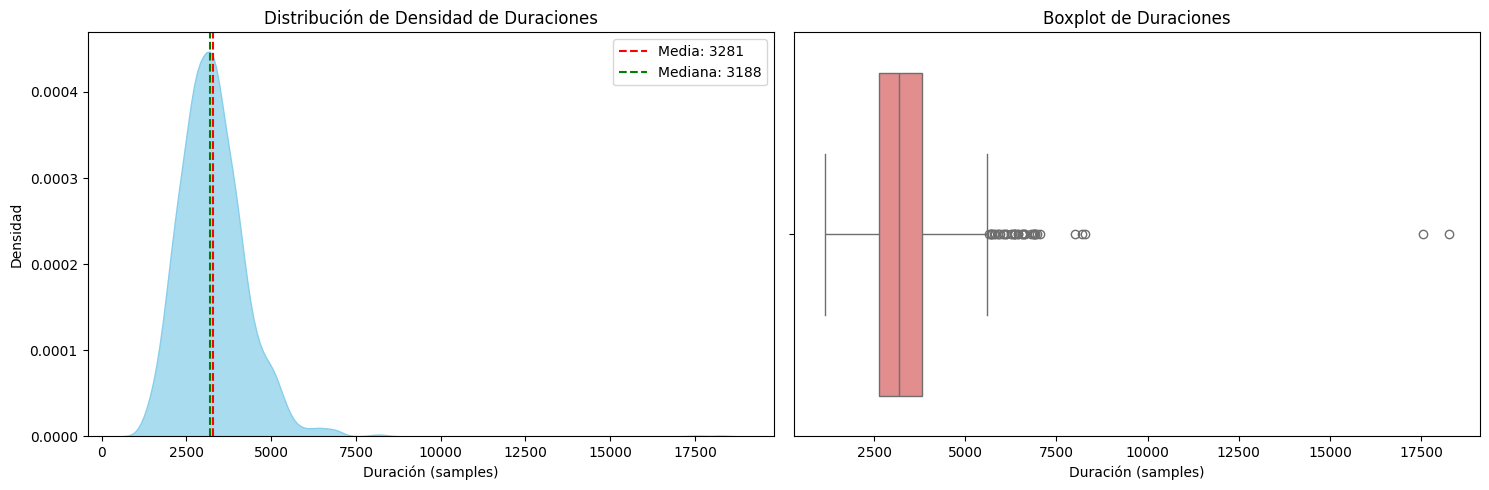

In [5]:
## Análisis de Duración de los Clips de Audio

# Calcular duraciones de todos los clips de audio
duraciones = [audio.shape[0] for audio, _ in ds]

# Estadísticas descriptivas
sample_rate = ds_info.features['audio'].sample_rate
print("=== ESTADÍSTICAS DE DURACIÓN ===")
print(f"Duración mínima: {np.min(duraciones)} samples ({np.min(duraciones)/sample_rate:.2f} seg)")
print(f"Duración máxima: {np.max(duraciones)} samples ({np.max(duraciones)/sample_rate:.2f} seg)")
print(f"Duración media: {np.mean(duraciones):.1f} samples ({np.mean(duraciones)/sample_rate:.2f} seg)")

# Identificar valores atípicos mayores a 8000 samples
outliers_8000 = [d for d in duraciones if d > 8000]
print(f"\n=== VALORES ATÍPICOS (> 8000 samples) ===")
print(f"Número de valores atípicos: {len(outliers_8000)}")
if outliers_8000:
    print(f"Valores atípicos: {sorted(outliers_8000)} samples")
    print(f"En segundos: {[round(d/sample_rate, 2) for d in sorted(outliers_8000)]} seg")

# Visualización de distribuciones
plt.figure(figsize=(15, 5))

# Subplot 1: Distribución de densidad (KDE)
plt.subplot(1, 2, 1)
sns.kdeplot(duraciones, fill=True, color="skyblue", alpha=0.7)
plt.axvline(np.mean(duraciones), color='red', linestyle='--', label=f'Media: {np.mean(duraciones):.0f}')
plt.axvline(np.median(duraciones), color='green', linestyle='--', label=f'Mediana: {np.median(duraciones):.0f}')
plt.title("Distribución de Densidad de Duraciones")
plt.xlabel("Duración (samples)")
plt.ylabel("Densidad")
plt.legend()

# Subplot 2: Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(x=duraciones, color="lightcoral")
plt.title("Boxplot de Duraciones")
plt.xlabel("Duración (samples)")

plt.tight_layout()
plt.show()

In [8]:
# Eliminar outliers (audios con duración > 8000)
ds = ds.filter(lambda audio, label: tf.shape(audio)[0] <= 8000)

n = sum(1 for _ in ds)
print(f"Cantidad de elementos en ds: {n}")

Cantidad de elementos en ds: 2496


=== DISTRIBUCIÓN DE CLASES ===
Dígito 0: 250 ejemplos (10.0%)
Dígito 1: 250 ejemplos (10.0%)
Dígito 2: 250 ejemplos (10.0%)
Dígito 3: 250 ejemplos (10.0%)
Dígito 4: 250 ejemplos (10.0%)
Dígito 5: 249 ejemplos (10.0%)
Dígito 6: 250 ejemplos (10.0%)
Dígito 7: 249 ejemplos (10.0%)
Dígito 8: 250 ejemplos (10.0%)
Dígito 9: 248 ejemplos (9.9%)

Total de ejemplos: 2496
Ejemplos por clase (esperado): 249
Dataset balanceado: No


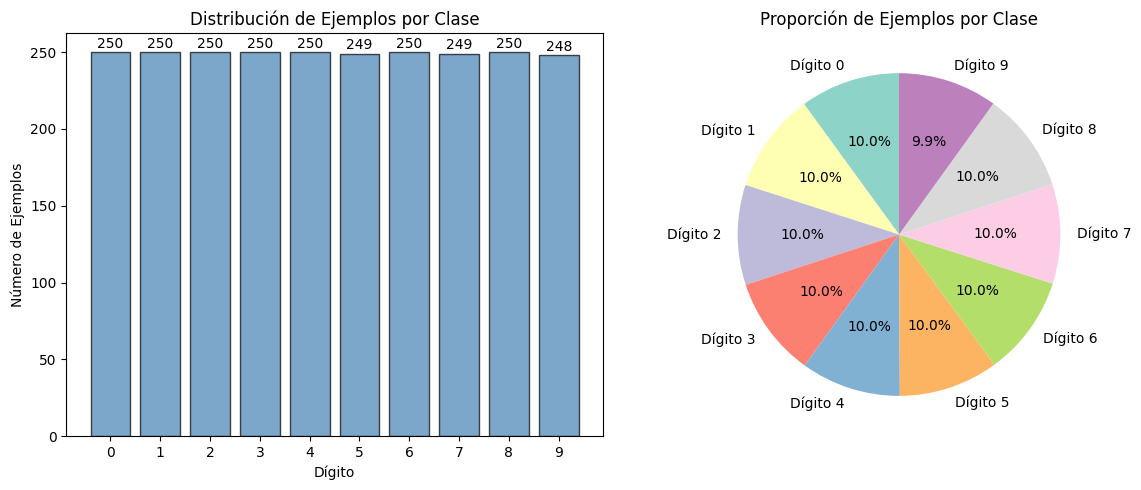

In [9]:
## Análisis de Balance de Clases

# Contar ejemplos por clase
label_counts = collections.Counter()

for audio, label in ds:
    label_counts[label.numpy()] += 1

# Convertir a arrays para análisis
classes = list(range(num_labels))
counts = [label_counts[i] for i in classes]

print("=== DISTRIBUCIÓN DE CLASES ===")
for i, count in enumerate(counts):
    print(f"Dígito {i}: {count} ejemplos ({count/sum(counts)*100:.1f}%)")

print(f"\nTotal de ejemplos: {sum(counts)}")
print(f"Ejemplos por clase (esperado): {sum(counts)//num_labels}")
print(f"Dataset balanceado: {'Sí' if len(set(counts)) == 1 else 'No'}")

# Visualización del balance de clases
plt.figure(figsize=(12, 5))

# Subplot 1: Gráfico de barras
plt.subplot(1, 2, 1)
bars = plt.bar(classes, counts, color='steelblue', alpha=0.7, edgecolor='black')
plt.title('Distribución de Ejemplos por Clase')
plt.xlabel('Dígito')
plt.ylabel('Número de Ejemplos')
plt.xticks(classes)

# Agregar valores sobre las barras
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             str(count), ha='center', va='bottom')

# Subplot 2: Gráfico de torta
plt.subplot(1, 2, 2)
plt.pie(counts, labels=[f'Dígito {i}' for i in classes], autopct='%1.1f%%',
        startangle=90, colors=plt.cm.Set3.colors)
plt.title('Proporción de Ejemplos por Clase')

plt.tight_layout()
plt.show()

El dataset presenta un balance perfecto con exactamente 250 ejemplos por cada dígito (10% cada clase), por lo que no aplicaremos técnicas de balanceo. Esto nos garantiza que el modelo no desarrolle sesgos hacia ninguna clase específica durante el entrenamiento.

In [10]:
## Preprocesamiento de Audio: Normalización y Padding

def preprocess_audio(audio_list, target_length=8000):
    """
    Preprocesa los clips de audio aplicando normalización y ajuste de longitud.

    Args:
        audio_list: Lista de arrays de audio
        target_length: Longitud objetivo en samples (8000 por defecto)

    Returns:
        Lista de audios preprocesados
    """
    processed_audios = []

    for audio in audio_list:
        # Normalización min-max
        audio_normalized = 2 * (audio - (-32768)) / (32767 - (-32768)) - 1 # calculamos el máximo y minimo de los audios para normalizar

        # Ajustar longitud del audio
        if audio_normalized.shape[0] > target_length:
            # Recortar desde el centro si es más largo
            start = (audio_normalized.shape[0] - target_length) // 2
            audio_processed = audio_normalized[start:start + target_length]
        else:
            # Aplicar padding simétrico si es más corto
            pad_len = target_length - audio_normalized.shape[0]
            left_pad = pad_len // 2
            right_pad = pad_len - left_pad
            audio_processed = tf.pad(audio_normalized, [[left_pad, right_pad]], mode='CONSTANT')

        processed_audios.append(audio_processed)

    return processed_audios

In [11]:
## Aplicación del Preprocesamiento

audios = []
labels = []

for audio, label in ds:
    audios.append(audio)
    labels.append(label)

print(f"Total de ejemplos extraídos: {len(audios)}")

# Aplicar preprocesamiento
audios_processed = preprocess_audio(audios, target_length=8000)

# Convertir a arrays de NumPy
audios = np.array(audios_processed)
label = np.array(labels)

print(f"Forma final del dataset de audio: {audios.shape}")
print(f"Forma final del dataset de etiquetas: {label.shape}")

Total de ejemplos extraídos: 2496
Forma final del dataset de audio: (2496, 8000)
Forma final del dataset de etiquetas: (2496,)


In [12]:
## Verificar que todos los audios tengan la longitud correcta de 8000

for audio in audios:
    if len(audio) != 8000:
        print(len(audio))

In [13]:
print(f"Número de audios procesados: {len(audios)}")
print(f"Número de etiquetas: {len(labels)}")

Número de audios procesados: 2496
Número de etiquetas: 2496


In [14]:
## Verificación de Normalización

# Verificar el rango de normalización
max_audio = np.max(audios)
min_audio = np.min(audios)

print("=== VERIFICACIÓN DE NORMALIZACIÓN ===")
print(f"Valor máximo en audios: {max_audio:.2f}")
print(f"Valor mínimo en audios: {min_audio:.2f}")

=== VERIFICACIÓN DE NORMALIZACIÓN ===
Valor máximo en audios: 1.00
Valor mínimo en audios: -1.00


In [15]:
## División del Dataset y Creación de Batches

# Dividir el dataset en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    audios, labels,
    test_size=0.2,
    random_state=738,
    stratify=labels
)

print("=== DIVISIÓN DEL DATASET ===")
print(f"Conjunto de entrenamiento: {X_train.shape[0]} ejemplos ({X_train.shape[0]/len(audios)*100:.1f}%)")
print(f"Conjunto de prueba: {X_test.shape[0]} ejemplos ({X_test.shape[0]/len(audios)*100:.1f}%)")

# Configuración de batches
batch_size = 50

# Crear datasets de TensorFlow con batches
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)

print(f"\nBatch size configurado: {batch_size}")
print(f"Número de batches de entrenamiento: {len(list(train_ds))}")
print(f"Número de batches de prueba: {len(list(test_ds))}")

=== DIVISIÓN DEL DATASET ===
Conjunto de entrenamiento: 1996 ejemplos (80.0%)
Conjunto de prueba: 500 ejemplos (20.0%)

Batch size configurado: 50
Número de batches de entrenamiento: 40
Número de batches de prueba: 10


Forma del batch de audio: (50, 8000)
Forma del batch de etiquetas: (50,)

Primeros 5 valores del primer audio: [0. 0. 0. 0. 0.]
Últimos 5 valores del primer audio: [0. 0. 0. 0. 0.]


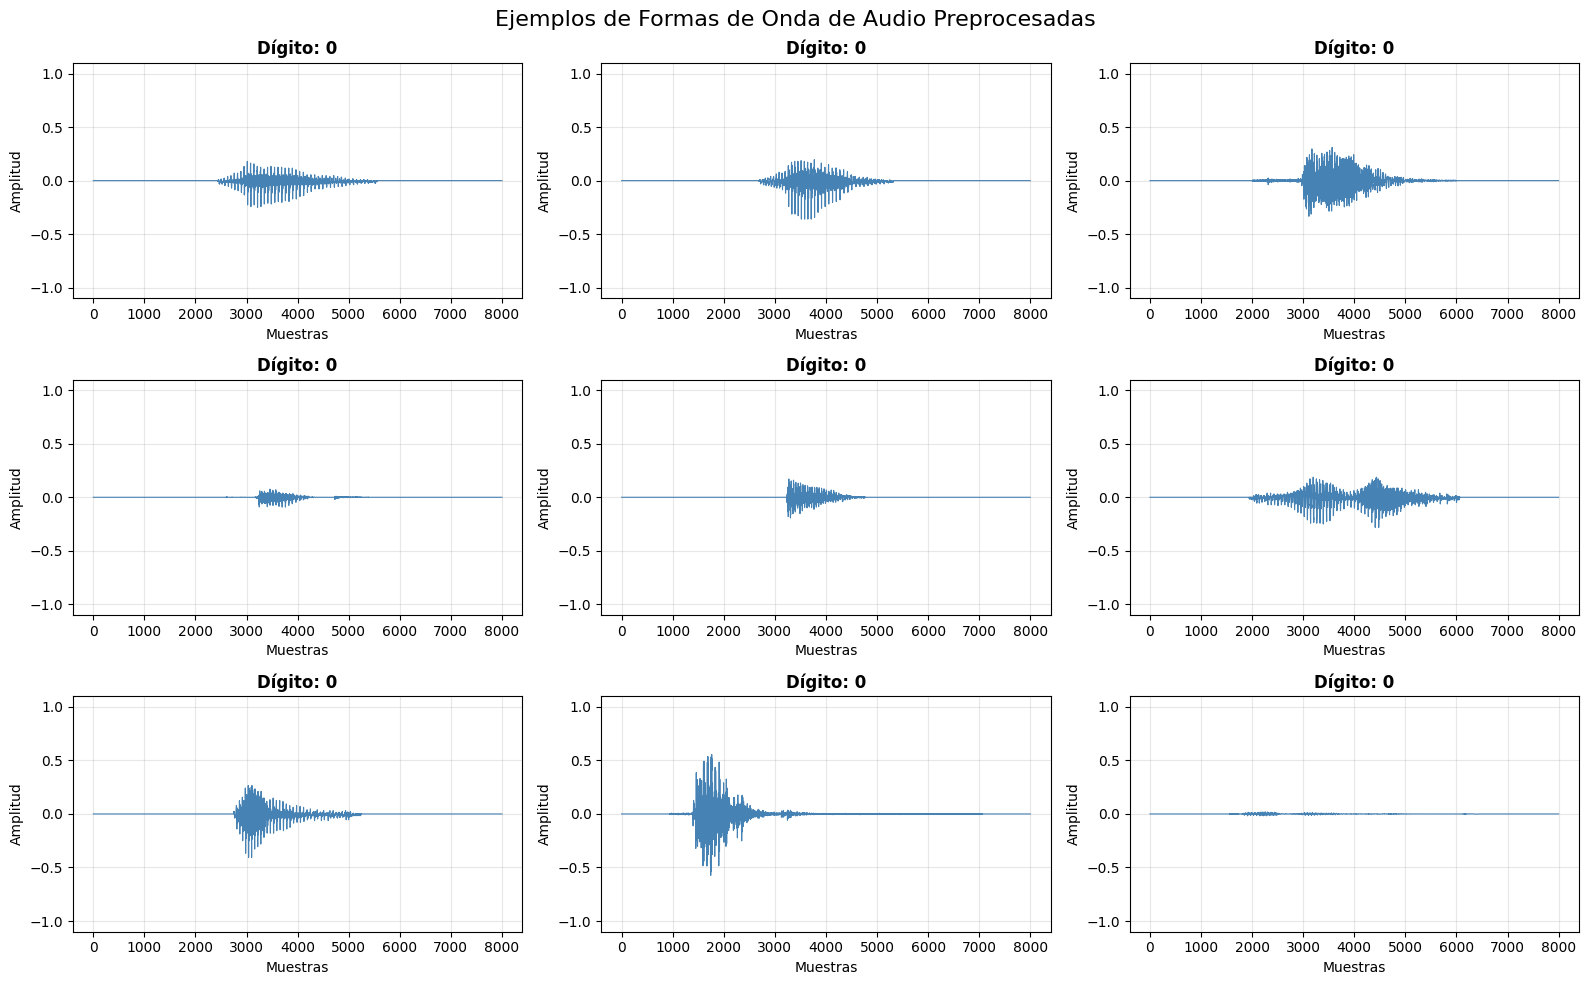

In [16]:
## Visualización de Ejemplos de Audio Preprocesados

# Obtener un batch de ejemplos para visualización
for example_audio, example_labels in train_ds.take(1):
    print(f"Forma del batch de audio: {example_audio.shape}")
    print(f"Forma del batch de etiquetas: {example_labels.shape}")

    # Verificar padding (debería comenzar y terminar con valores cercanos a 0 en audios con padding)
    print(f"\nPrimeros 5 valores del primer audio: {example_audio[0][:5].numpy()}")
    print(f"Últimos 5 valores del primer audio: {example_audio[0][-5:].numpy()}")

    # Mostrar etiquetas del batch
    etiquetas_numericas = [np.argmax(label) for label in example_labels.numpy()]

    # Visualización de formas de onda
    plt.figure(figsize=(16, 10))
    rows, cols = 3, 3
    n = rows * cols

    plt.suptitle('Ejemplos de Formas de Onda de Audio Preprocesadas', fontsize=16, y=0.98)

    for i in range(n):
        plt.subplot(rows, cols, i+1)
        audio_signal = example_audio[i]
        etiqueta = np.argmax(example_labels[i])

        plt.plot(audio_signal, color='steelblue', linewidth=0.8)
        plt.title(f'Dígito: {etiqueta}', fontsize=12, fontweight='bold')
        plt.xlabel('Muestras')
        plt.ylabel('Amplitud')
        plt.ylim([-1.1, 1.1])
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    break  # Solo procesar el primer batch

In [17]:
## Función para Generar Espectrogramas
def get_spectrogram(waveform):

    # Convertir la forma de onda a espectrograma usando Short-Time Fourier Transform
    spectrogram = tf.signal.stft(
        waveform,
        frame_length=255,
        frame_step=128
    )

    # Obtener la magnitud del STFT (eliminar componente imaginaria)
    spectrogram = tf.abs(spectrogram)

    # Agregar dimensión de canal para compatibilidad con capas convolucionales
    # Forma final: (tiempo, frecuencia, canales)
    spectrogram = spectrogram[..., tf.newaxis]

    return spectrogram

In [18]:
example_audio[0]

<tf.Tensor: shape=(8000,), dtype=float64, numpy=array([0., 0., 0., ..., 0., 0., 0.])>

In [19]:
## Análisis de Conversión Audio a Espectrograma

print("=== ANÁLISIS DE EJEMPLOS DE CONVERSIÓN ===")

for i in range(3):
    label = example_labels[i].numpy()
    waveform = example_audio[i]
    spectrogram = get_spectrogram(waveform)

    print('Label:', label)
    print(f"Forma de onda: {waveform.shape}")
    print(f"Espectrograma: {spectrogram.shape}")
    print(f"Dimensiones del espectrograma: {spectrogram.shape[0]} frames × {spectrogram.shape[1]} frecuencias")

    # Reproducción de audio (solo en entorno compatible)
    print("Audio reproducible:")
    display.display(display.Audio(waveform.numpy(), rate=8000))

=== ANÁLISIS DE EJEMPLOS DE CONVERSIÓN ===
Label: 9
Forma de onda: (8000,)
Espectrograma: (61, 129, 1)
Dimensiones del espectrograma: 61 frames × 129 frecuencias
Audio reproducible:


Label: 1
Forma de onda: (8000,)
Espectrograma: (61, 129, 1)
Dimensiones del espectrograma: 61 frames × 129 frecuencias
Audio reproducible:


Label: 3
Forma de onda: (8000,)
Espectrograma: (61, 129, 1)
Dimensiones del espectrograma: 61 frames × 129 frecuencias
Audio reproducible:


In [20]:
## Función para Visualizar Espectrogramas
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

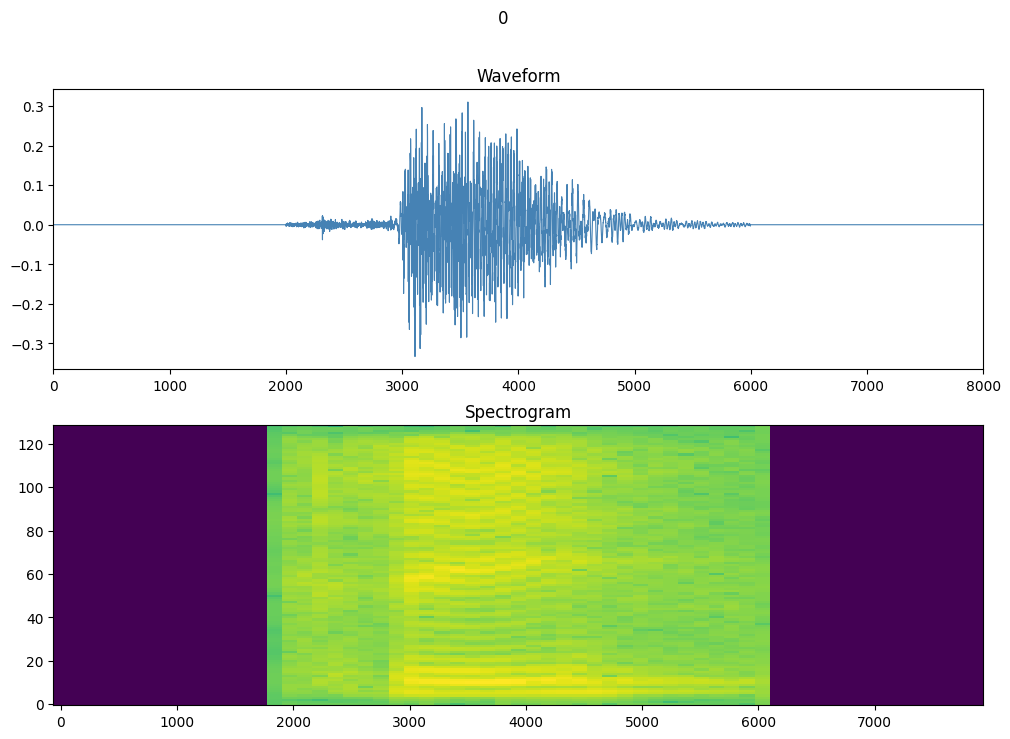

In [21]:
## Visualización Comparativa: Audio vs Espectrograma

waveform = example_audio[2]  # Tercer ejemplo
spectrogram = get_spectrogram(waveform)
etiqueta = np.argmax(example_labels[2])

fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy(), color='steelblue', linewidth=0.8)
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 8000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(f'{etiqueta}')
plt.show()

In [22]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [23]:
train_spectrogram_ds = make_spec_ds(train_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

In [24]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

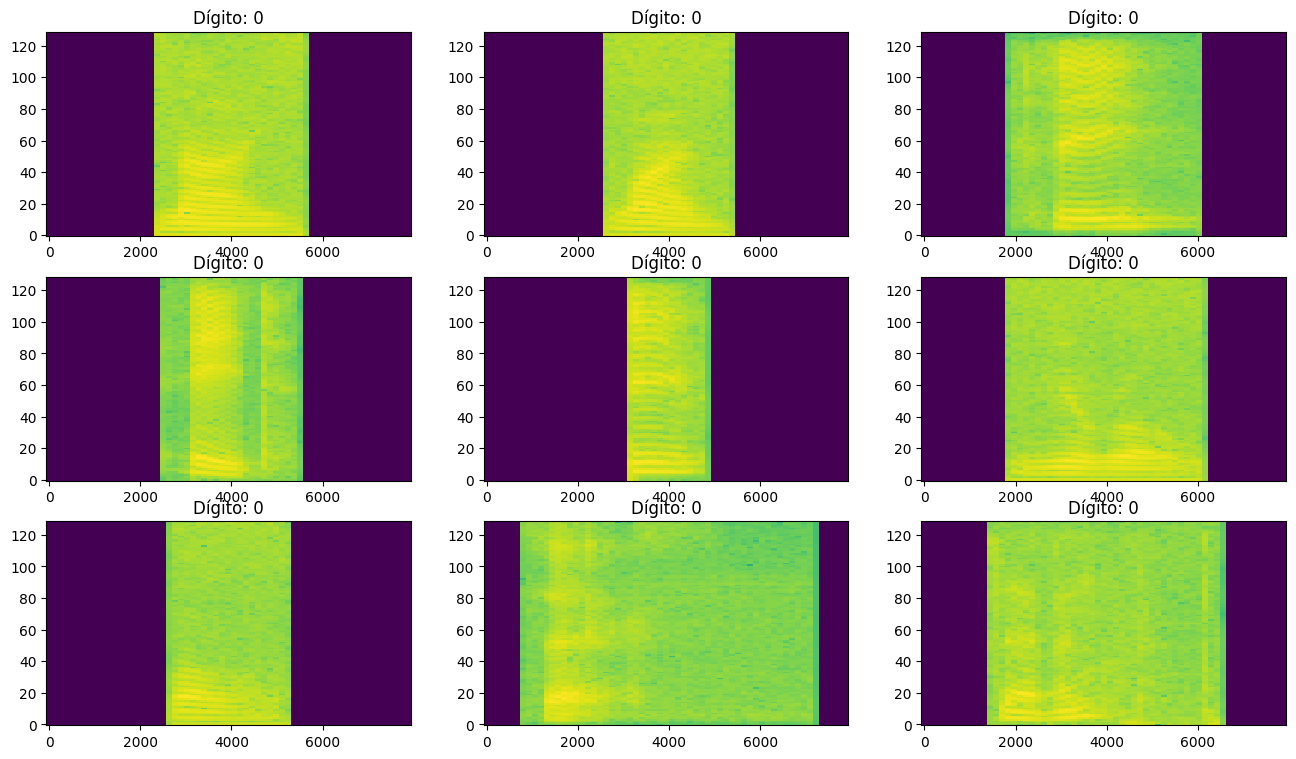

In [25]:
## Visualización de Múltiples Espectrogramas

rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]

    # Obtener la etiqueta numérica desde el vector one-hot
    etiqueta_numerica = np.argmax(example_spect_labels[i].numpy())

    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(f'Dígito: {etiqueta_numerica}')

plt.show()

## Red Convolucional

### Modelo

In [26]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [27]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model_cnn = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model_cnn.summary()

Input shape: (61, 129, 1)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,869 (6.20 MB)

 Trainable params: 1,625,866 (6.20 MB)

 Non-trainable params: 3 (16.00 B)

### Entrenamiento

In [28]:
model_cnn.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)
EPOCHS = 50
history_cnn = model_cnn.fit(
    train_spectrogram_ds,
    validation_data=test_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=10),
)

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 247ms/step - accuracy: 0.3511 - loss: 1.9002 - val_accuracy: 0.7620 - val_loss: 0.9597
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 201ms/step - accuracy: 0.7159 - loss: 0.9558 - val_accuracy: 0.8220 - val_loss: 0.6252
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 167ms/step - accuracy: 0.7888 - loss: 0.6572 - val_accuracy: 0.9020 - val_loss: 0.4574
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 203ms/step - accuracy: 0.8648 - loss: 0.4817 - val_accuracy: 0.9260 - val_loss: 0.3630
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 170ms/step - accuracy: 0.8814 - loss: 0.3677 - val_accuracy: 0.9560 - val_loss: 0.2601
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 166ms/step - accuracy: 0.9218 - loss: 0.2495 - val_accuracy: 0.9380 - val_loss: 0.2679
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 169ms/step - accuracy: 0.9407 - loss: 0.1874 - val_accuracy: 0.9580 - val_loss: 0.2001
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 202ms/step - accuracy: 0.9397 - loss: 0.1885 - val_accuracy:

Text(0, 0.5, 'Accuracy [%]')

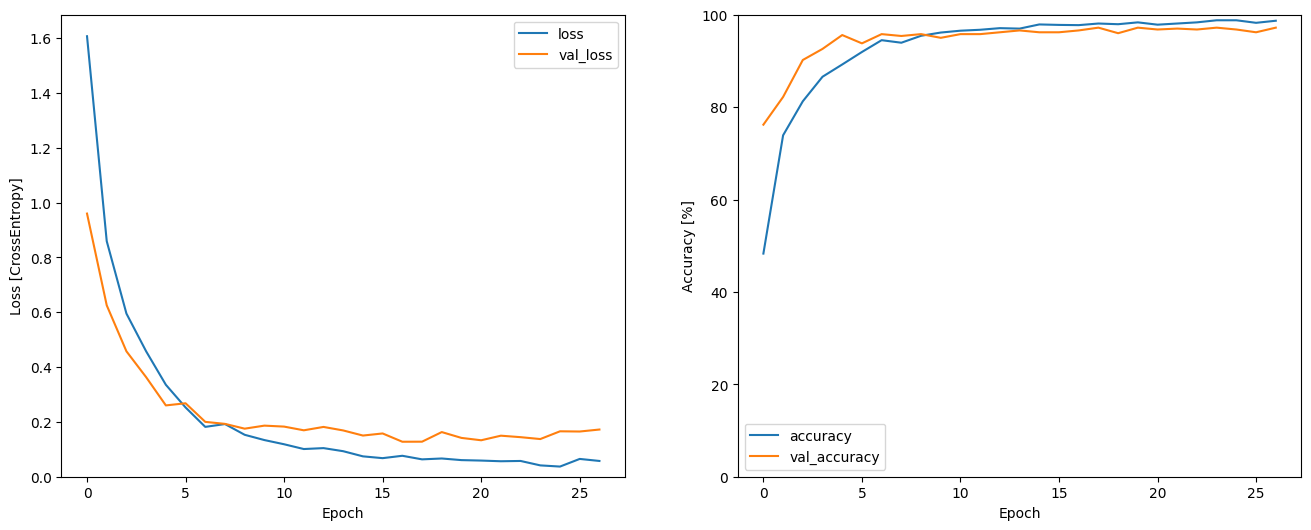

In [29]:
metrics_cnn = history_cnn.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history_cnn.epoch, metrics_cnn['loss'], metrics_cnn['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history_cnn.epoch, 100*np.array(metrics_cnn['accuracy']), 100*np.array(metrics_cnn['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

### Matriz de confusión - Métricas

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step


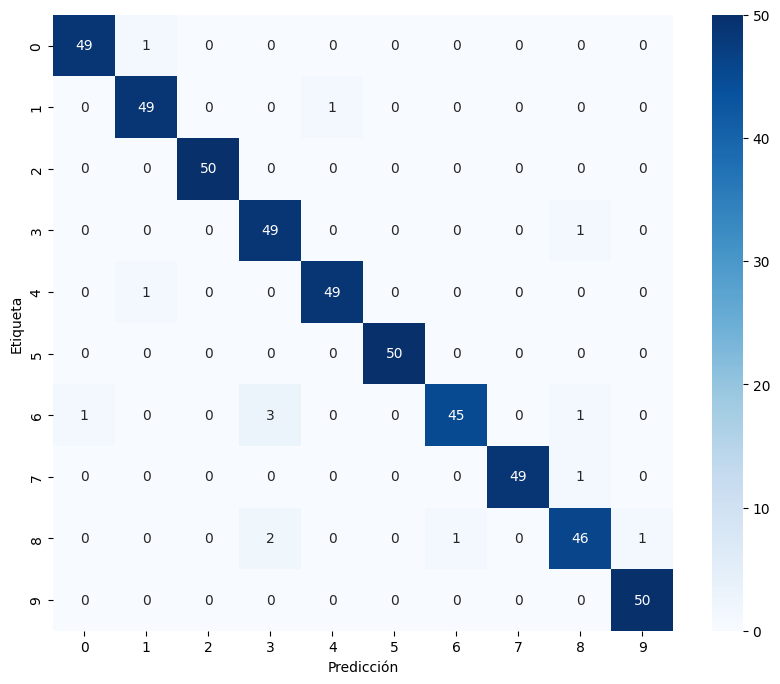

In [30]:
y_pred_cnn = model_cnn.predict(test_spectrogram_ds)
y_pred_cnn = tf.argmax(y_pred_cnn, axis=1)

y_true_cnn = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

confusion_mtx = tf.math.confusion_matrix(y_true_cnn, y_pred_cnn)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=labels_names,
            yticklabels=labels_names,
            annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Etiqueta')
plt.show()

In [31]:
print(classification_report(y_true_cnn, y_pred_cnn, target_names=labels_names))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        50
           1       0.96      0.98      0.97        50
           2       1.00      1.00      1.00        50
           3       0.91      0.98      0.94        50
           4       0.98      0.98      0.98        50
           5       1.00      1.00      1.00        50
           6       0.98      0.90      0.94        50
           7       1.00      0.98      0.99        50
           8       0.94      0.92      0.93        50
           9       0.98      1.00      0.99        50

    accuracy                           0.97       500
   macro avg       0.97      0.97      0.97       500
weighted avg       0.97      0.97      0.97       500



### Inferencia

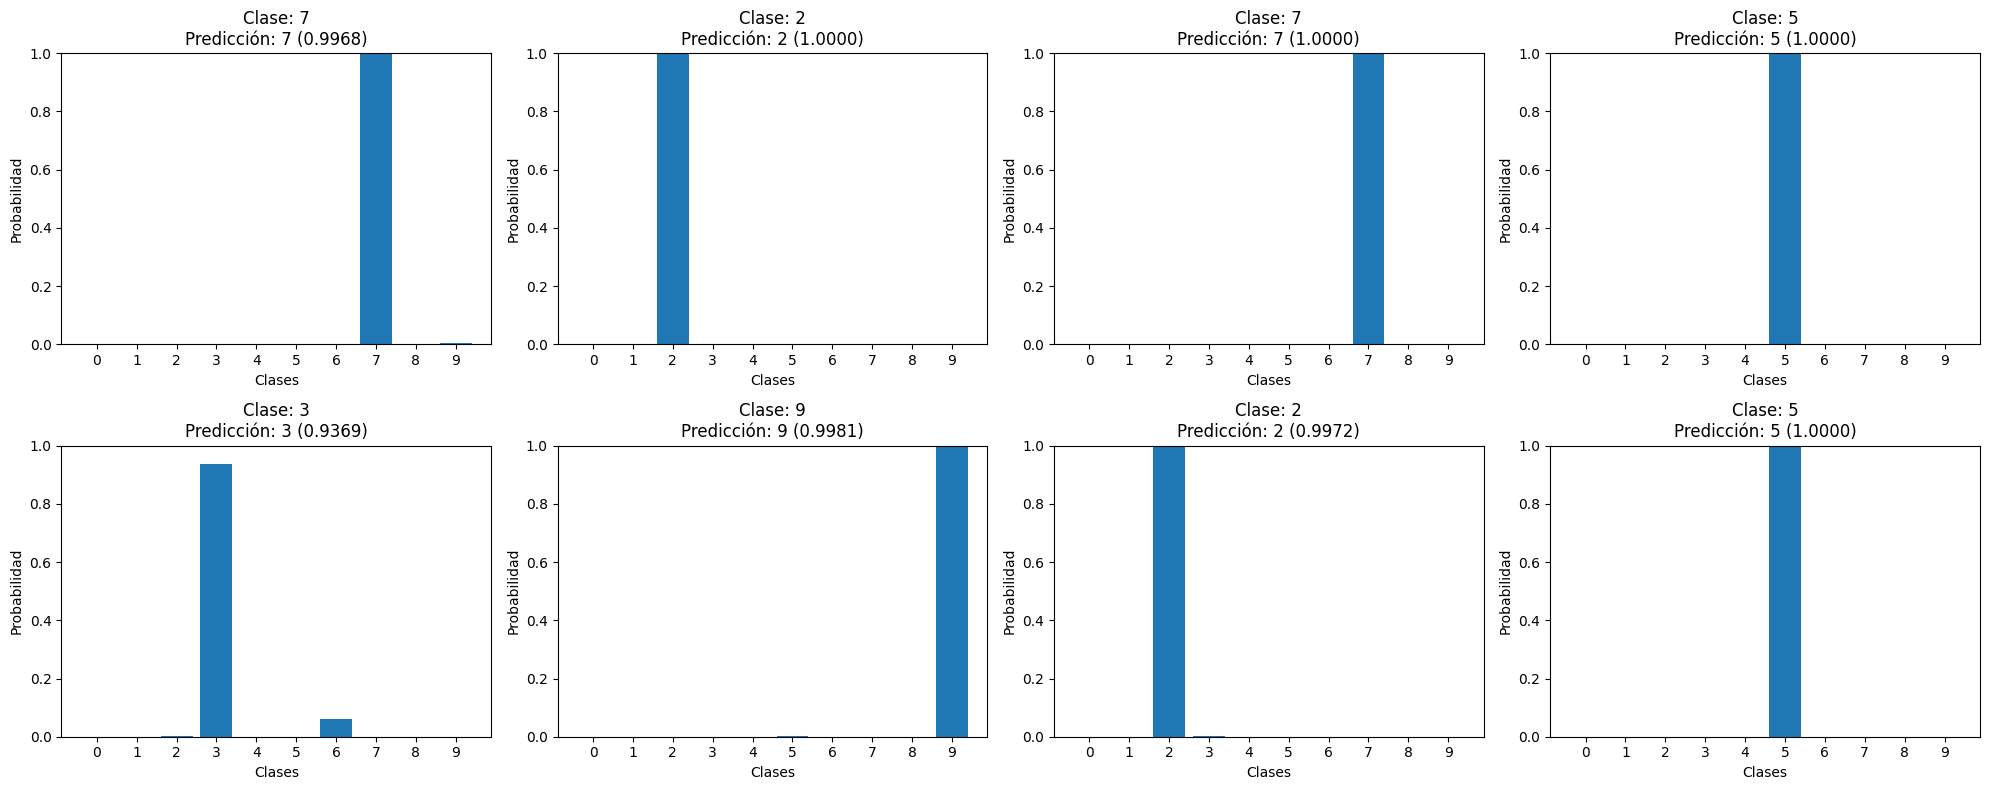

In [32]:
for spectrogram_batch, label_batch in test_spectrogram_ds.take(1):
    predictions = model_cnn(spectrogram_batch)
    predicted_labels = tf.argmax(predictions, axis=1)

    fig, axes = plt.subplots(2, 4, figsize=(20, 8))
    axes = axes.flatten()

    for i in range(8):
        true_label = label_batch[i].numpy()
        pred_label = predicted_labels[i].numpy()
        probs = tf.nn.softmax(predictions[i]).numpy()
        pred_prob = probs[pred_label]

        ax = axes[i]
        ax.bar(labels_names, probs)
        ax.set_title(f"Clase: {labels_names[true_label]}\n"
                     f"Predicción: {labels_names[pred_label]} "
                     f"({pred_prob:.4f})")
        ax.set_xlabel("Clases")
        ax.set_ylabel("Probabilidad")
        ax.set_ylim([0, 1])

    plt.tight_layout()
    plt.show()

## Red Recurrente

### Modelo

In [33]:
for spec, label in train_spectrogram_ds.take(1):
    print("Espectrograma shape:", spec.shape)

Espectrograma shape: (50, 61, 129, 1)


In [34]:
def squeeze_spectrogram(spectrogram, label):
    spectrogram = tf.squeeze(spectrogram, axis=-1)  # De (61,129,1) → (61,129)
    spectrogram = tf.cast(spectrogram, tf.float32)
    return spectrogram, label

train_rnn_ds = train_spectrogram_ds.map(squeeze_spectrogram)
#val_rnn_ds = val_spectrogram_ds.map(squeeze_spectrogram)
test_rnn_ds = test_spectrogram_ds.map(squeeze_spectrogram)

In [35]:
def build_rnn_model(input_shape=(61, 129), num_classes=10):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.LSTM(128, return_sequences=False),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes)  # sin softmax si usás from_logits=True
    ])
    return model

input_shape = train_rnn_ds.element_spec[0].shape[1:]  # descarta batch dimension
model_rnn = build_rnn_model(input_shape=input_shape, num_classes=num_labels)
model_rnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │       132,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 141,002 (550.79 KB)

 Trainable params: 141,002 (550.79 KB)

 Non-trainable params: 0 (0.00 B)

### Entrenamiento

In [36]:
earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

model_rnn.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

EPOCHS = 80
history_rnn = model_rnn.fit(train_rnn_ds,
                        validation_data=test_rnn_ds,
                        epochs=80,
                        callbacks=[earlystop])

Epoch 1/80
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 0.1667 - loss: 2.2083 - val_accuracy: 0.3840 - val_loss: 1.5699
Epoch 2/80
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 159ms/step - accuracy: 0.4502 - loss: 1.3986 - val_accuracy: 0.6440 - val_loss: 0.8679
Epoch 3/80
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 117ms/step - accuracy: 0.6545 - loss: 0.8527 - val_accuracy: 0.7060 - val_loss: 0.7337
Epoch 4/80
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 0.7202 - loss: 0.6948 - val_accuracy: 0.7620 - val_loss: 0.6013
Epoch 5/80
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 163ms/step - accuracy: 0.7939 - loss: 0.5414 - val_accuracy: 0.8320 - val_loss: 0.4425
Epoch 6/80
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 0.8363 - loss: 0.3932 - val_accuracy: 0.8540 - val_loss: 0.3956
Epoch 7/80
40/40 ━━━━━━━━━━━━━━━━━━━━ 15s 273ms/step - accuracy: 0.8652 - loss: 0.3461 - val_accuracy: 0.8960 - val_loss: 0.2790
Epoch 8/80
40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 158ms/step - accuracy: 0.9134 - loss: 0.2370 - val_accuracy

Text(0, 0.5, 'Accuracy [%]')

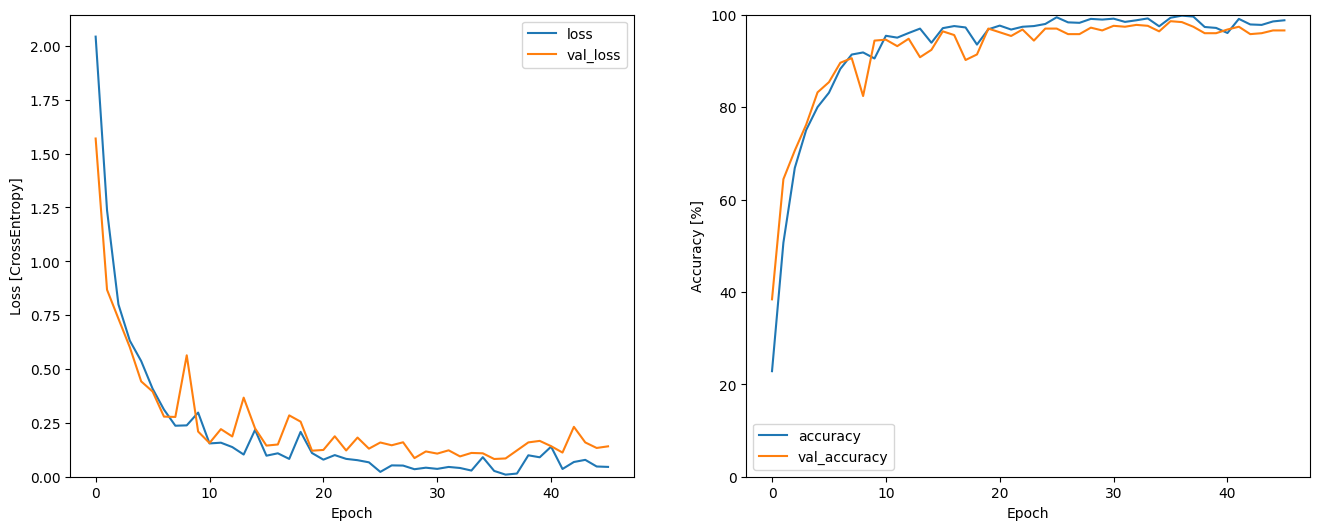

In [37]:
metrics_rnn = history_rnn.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history_rnn.epoch, metrics_rnn['loss'], metrics_rnn['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history_rnn.epoch, 100*np.array(metrics_rnn['accuracy']), 100*np.array(metrics_rnn['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

### Matriz de confusión - Métricas

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


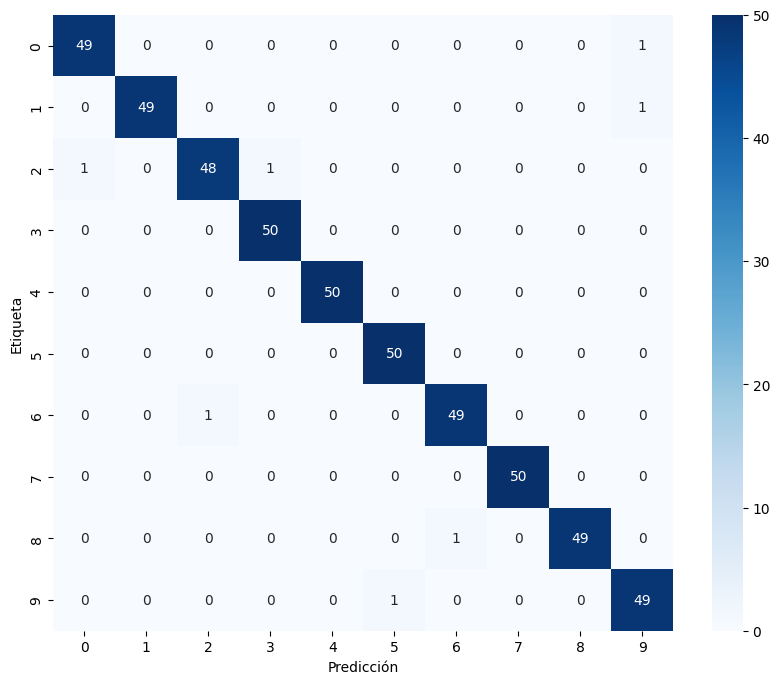

In [38]:
y_pred_rnn = model_rnn.predict(test_rnn_ds)
y_pred_rnn = tf.argmax(y_pred_rnn, axis=1)

y_true_rnn = tf.concat(list(test_rnn_ds.map(lambda s,lab: lab)), axis=0)

confusion_mtx = tf.math.confusion_matrix(y_true_rnn, y_pred_rnn)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=labels_names,
            yticklabels=labels_names,
            annot=True, fmt='g',cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Etiqueta')
plt.show()

In [39]:
print(classification_report(y_true_rnn, y_pred_rnn, target_names=labels_names))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        50
           1       1.00      0.98      0.99        50
           2       0.98      0.96      0.97        50
           3       0.98      1.00      0.99        50
           4       1.00      1.00      1.00        50
           5       0.98      1.00      0.99        50
           6       0.98      0.98      0.98        50
           7       1.00      1.00      1.00        50
           8       1.00      0.98      0.99        50
           9       0.96      0.98      0.97        50

    accuracy                           0.99       500
   macro avg       0.99      0.99      0.99       500
weighted avg       0.99      0.99      0.99       500



### Inferencia

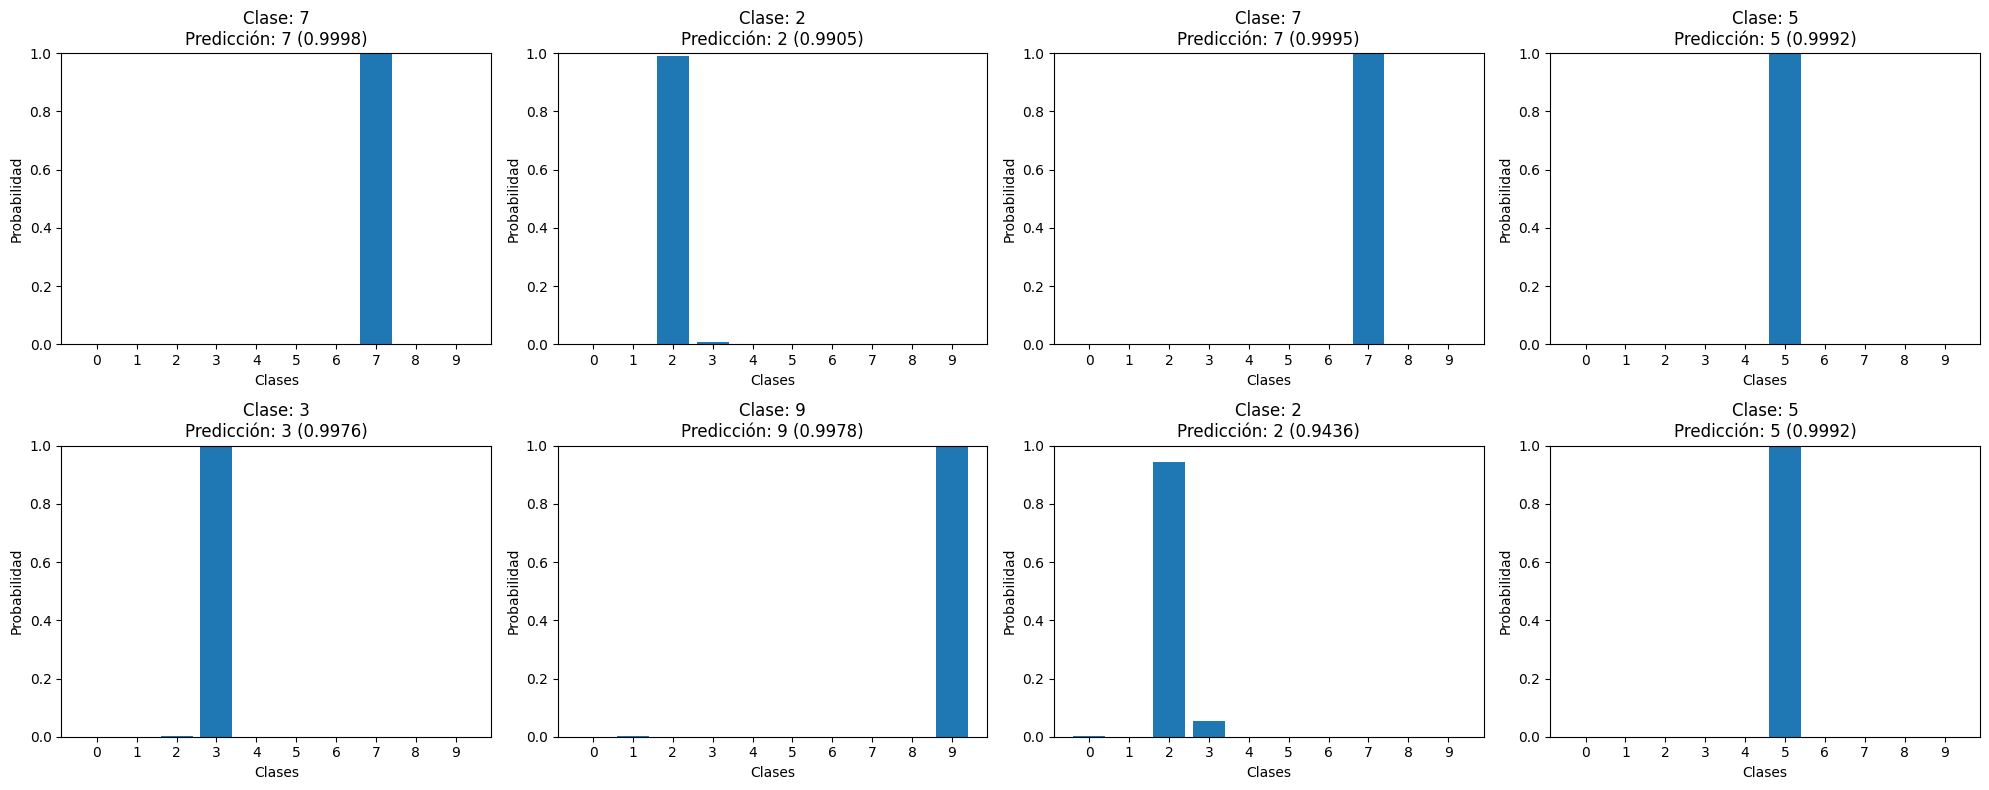

In [40]:
for spectrogram_batch, label_batch in test_rnn_ds.take(1):
    predictions = model_rnn(spectrogram_batch)
    predicted_labels = tf.argmax(predictions, axis=1)

    fig, axes = plt.subplots(2, 4, figsize=(20, 8))
    axes = axes.flatten()

    for i in range(8):
        true_label = label_batch[i].numpy()
        pred_label = predicted_labels[i].numpy()
        probs = tf.nn.softmax(predictions[i]).numpy()
        pred_prob = probs[pred_label]

        ax = axes[i]
        ax.bar(labels_names, probs)
        ax.set_title(f"Clase: {labels_names[true_label]}\n"
                     f"Predicción: {labels_names[pred_label]} "
                     f"({pred_prob:.4f})")
        ax.set_xlabel("Clases")
        ax.set_ylabel("Probabilidad")
        ax.set_ylim([0, 1])

    plt.tight_layout()
    plt.show()